In [1]:
network = [
    ("Age", "ChestPainType"),
    ("Age", "Cholesterol"),
    ("Age", "RestingBP"),
    ("Age", "FastingBS"),
    ("Age", "MaxHR"),
    ("Age", "RestingECG"),
    ("Sex", "Cholesterol"),
    ("Sex", "FastingBS"),
    ("RestingECG", "Oldpeak"),
    ("RestingECG", "ST_Slope"),
    ("RestingECG", "ChestPainType"),
    ("RestingBP", "ExerciseAngina"),
    ("Oldpeak", "ST_Slope"),
    ("ChestPainType", "HeartDisease"),
    ("Cholesterol", "HeartDisease"),
    ("ExerciseAngina", "HeartDisease"),
    ("FastingBS", "HeartDisease"),
    ("MaxHR", "HeartDisease"),
    ("ST_Slope", "HeartDisease"),
    ("ChestPainType", "HeartDisease"),
    ("Age", "HeartDisease"),
    ("Cholesterol", "RestingBP"),
    ("Sex", "HeartDisease")
]

In [2]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import networkx as nx

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import *
from pgmpy.inference import VariableElimination
from pgmpy.metrics import *
from pgmpy.metrics.bn_inference import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import warnings
warnings.filterwarnings("ignore")

/home/matteo/Documenti/VSCODE/BayesianClassifier/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
nb_model = BayesianNetwork(network)

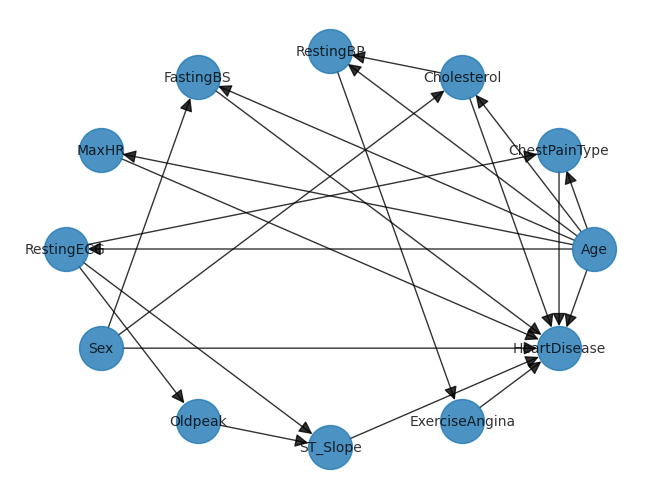

In [4]:
nx.draw_circular(nb_model, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)
plt.show()

In [5]:
df = pd.read_csv(f'data{os.sep}heart.csv')
df = df[~(df['Cholesterol'] == 0) & ~(df['RestingBP'] == 0)]
df['ExerciseAngina'] = df['ExerciseAngina'].apply(lambda x: False if x == 'N' else True)
df['HeartDisease'] = df['HeartDisease'].apply(lambda x: False if x == 0 else True)
df['FastingBS'] = df['FastingBS'].apply(lambda x: False if x == 0 else True)
df["Age"] = pd.qcut(x=df["Age"], q=2, labels=["young", "old"])
df["RestingBP"] = pd.cut(x=df["RestingBP"], bins=[90, 120, 140, 1000], labels=["normal", "high", "very high"])
df["Cholesterol"] = pd.cut(x=df["Cholesterol"], bins=[0, 200, 240, 1000], labels=["optimal", "borderline", "high"])
df["MaxHR"] = pd.cut(x=df["MaxHR"], bins=3)
df["Oldpeak"] = pd.cut(x=df["Oldpeak"], bins=3, labels=["low", "medium", "high"])


In [6]:
target_variable = "HeartDisease"
X, y = df.drop(columns=target_variable), df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train = pd.concat([X_train, y_train], axis=1)


In [7]:
estimator = BayesianEstimator(nb_model, train)

In [8]:
for _ in estimator.get_parameters():
    nb_model.add_cpds(_)

In [9]:
ypred = nb_model.predict(X_test)

100%|██████████| 141/141 [00:00<00:00, 1014.25it/s]


In [10]:
accuracy_score(y_test, ypred[target_variable])

0.8

In [11]:
roc_auc_score(y_test, ypred)

0.8087003030843287

In [165]:
net = HillClimbSearch(df).estimate(start_dag=nb_model, scoring_method="bdeuscore", tabu_length=10)

  0%|          | 29/1000000 [00:01<9:44:50, 28.50it/s]


In [137]:
estimator = BayesianEstimator(net, df)

In [167]:
for _ in estimator.get_parameters():
    net.add_cpds(_)

In [168]:
ypred = net.predict(df.drop(target_variable, axis=1))

100%|██████████| 581/581 [00:00<00:00, 3974.20it/s]


In [169]:
accuracy_score(ypred, ytrue)

0.871313672922252

In [170]:
roc_auc_score(ytrue, ypred)

0.8722702391241717

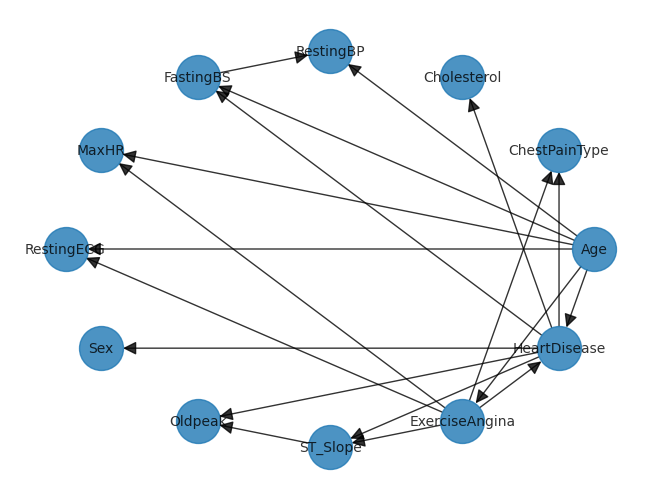

In [171]:
nx.draw_circular(net, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)
plt.show()